In [ ]:
#!git clone https://github.com/shiftmark/HPA-SingleCellClassification.git
#!git clone https://github.com/CellProfiling/HPA-Cell-Segmentation.git
#!cd HPA-Cell-Segmentation && sh install.sh
#!pip uninstall PIL && pip uninstall Pillow -y && pip install Pillow
# restart for Pillow

In [4]:
import sys
import os
import random
import cv2
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
sys.path.insert(0, '../src/')
sys.path.insert(0, '../tests/')

from utils.download_files import DownloadFile
from utils.create_tfrecord import CreateTFRecord
from utils.parse_example import ParseExample
from train.helpers import plot_images, plot_history
from train.augment import Augment
from train.get_model import GetModel
import train.constants as c


In [ ]:
dg.download(8, SAVE_IMG_TO)

In [ ]:
import pandas as pd
df = c.DF
# Create a pd.Series with one-hot encoded values and merge it with dataframe
df =df.merge(pd.Series(c.DF.Label_idx).str.get_dummies(), right_index=True, left_on=df.index)
# Keep just 'Image', '0', '1', ..., '18' columns
df.drop(['key_0', 'Label', 'Cellline', 'in_trainset', 'Label_idx'], inplace=True, axis=1)
# Create column 'Name' for image names
df['Name'] = df.Image.map(lambda x: x.split('/')[-1])
# Create 'Labels' column, containing one-hot encoded arrays
df['Labels'] = df[[str(s) for s in range(19)]].apply(lambda x: list(x), axis=1)
# Drop '0', '1', ..., '18' columns
df.drop([str(s) for s in range(19)], axis=1, inplace=True)
# Set 'Name' as index
df.set_index('Name', inplace=True)


In [ ]:
CreateTFRecord(c.MULTICHANNEL_IMGS, df).write_to(c.SAVE_TFREC_TO, num_items_in_record=13)

In [15]:
imgs = []
filenames = glob.glob(f'{c.SAVE_TFREC_TO}/*.tfrec')
dataset = tf.data.TFRecordDataset(filenames)

for i in dataset.take(3):
    
    imgs.append(ParseExample(i, return_img_name=True).parse_eg()[1])
    
data = tf.data.Dataset.from_tensor_slices(imgs)
data2 = Augment(flip_vertical=True,
                flip_horizontal=True,
                seed=tf.random.uniform((2,),maxval=9, dtype=tf.int32),
                contrast={'lower':.5, 'upper':.9},
                brightness={'max_delta':.9},
                saturation={'lower':.2, 'upper':.7}
                ).apply_on(data)

                


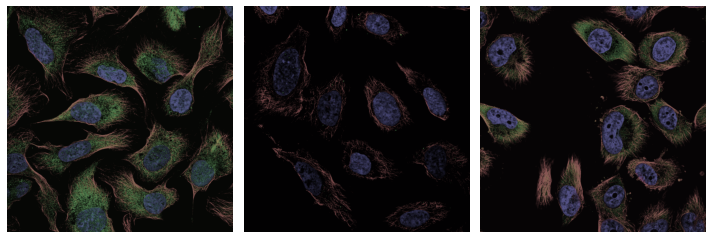

In [16]:
ar = []
for i in data2.take(8):
    ar.append(i)
plot_images(ar, show_axes=False)

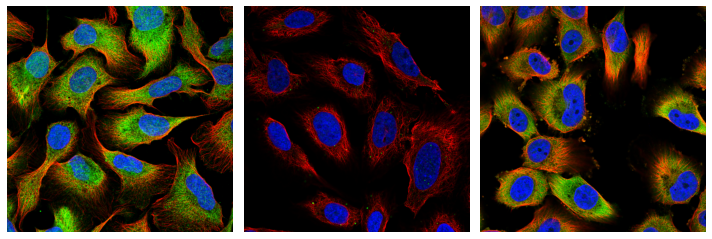

In [17]:
plot_images(imgs, show_axes=False)

In [ ]:
model = GetModel().set_backbone("EfficientNetB0", input_shape=(224,224,3), include_top=True)
model = tf.keras.Model(inputs=model.inputs, outputs=model.outputs)
#model.summary()


model2 = GetModel().set_backbone("EfficientNetB7", input_shape=(600,600,3), include_top=False).add_top(23,.4,33)

#model = Unet((32, 800, 3), 7).unet()

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(model)

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])


In [ ]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])


In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
tf.debugging.experimental.enable_dump_debug_info(log_dir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)